In [2]:
import numpy as np
import importlib
import matplotlib.cm as cm
import time
from IPython.display import Video

import ca_environment as caenv
import ca_agent as caag

import neat
import neat_stuff.visualize as visualize
import os

In [426]:
importlib.reload(caenv)
importlib.reload(caag)
importlib.reload(visualize)

<module 'neat_stuff.visualize' from '/Users/aidanbarbieux/CSC/580-CSC/WIDDAK/nca/neat_stuff/visualize.py'>

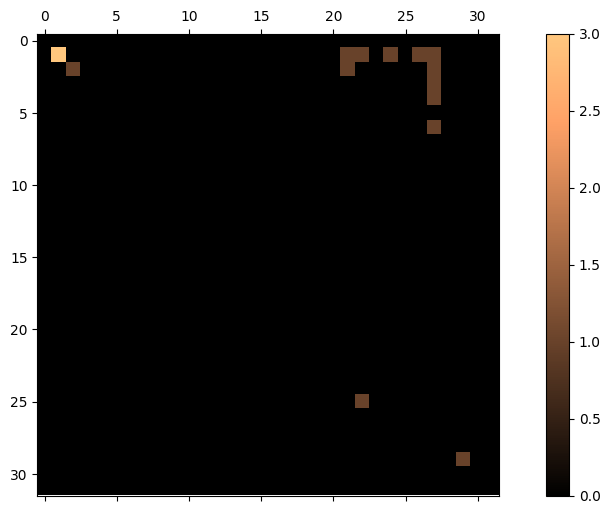

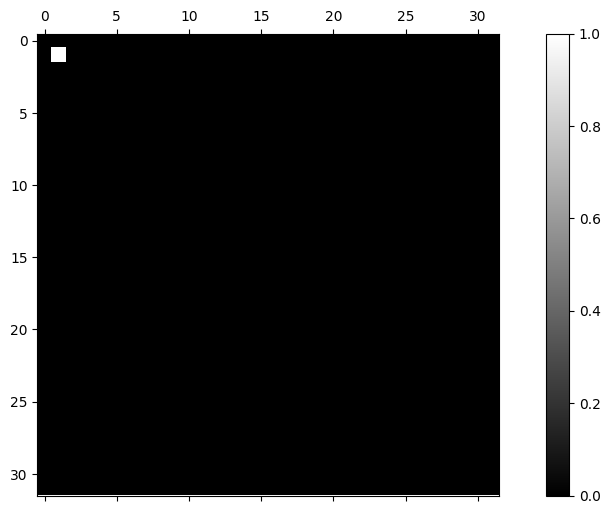

In [427]:
env = caenv.CAEnvironment()
env.gen_padded_food()
env.innoculate()
env.display()


In [428]:
ag = caag.CAAgent()
def lame_rules(chunk, env):
    return [1] * env.n_channels

ag.set_rule_func(lame_rules)

In [429]:
rag = caag.CAAgent()
def rand_rules(chunk, env):
    return np.random.random(env.n_channels)
rag.set_rule_func(rand_rules)

In [432]:
env.start_new_video(channels=(env.food_i, env.life_i), cmaps = (cm.copper,cm.gray))
for _ in range(30):
    # ag.apply_to_env(env, log=True, vid_speed=3)
    rag.apply_to_env(env, log=True, vid_speed=5)

In [433]:
Video(env.gen_video())

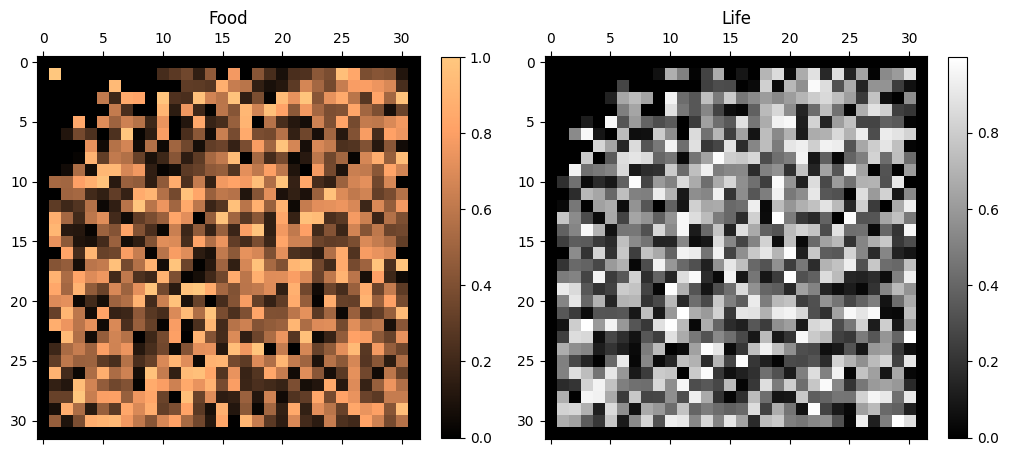

In [9]:
env.display()

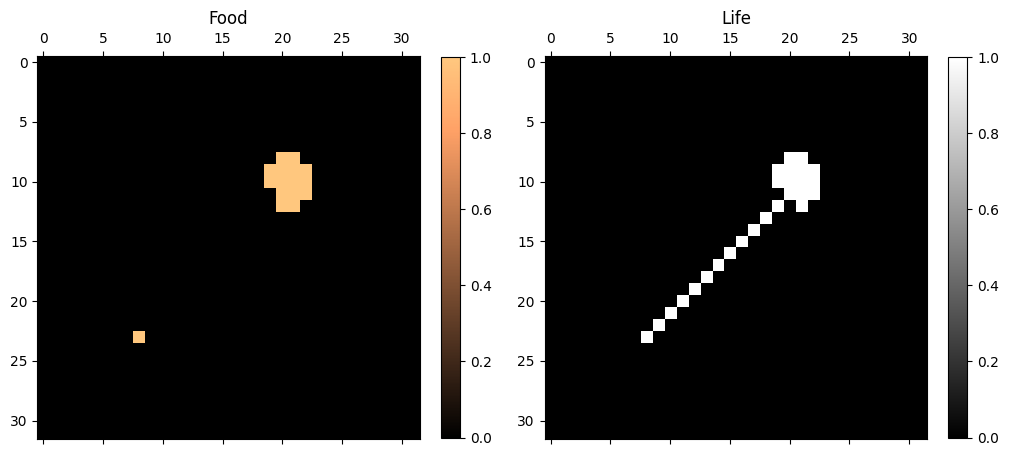

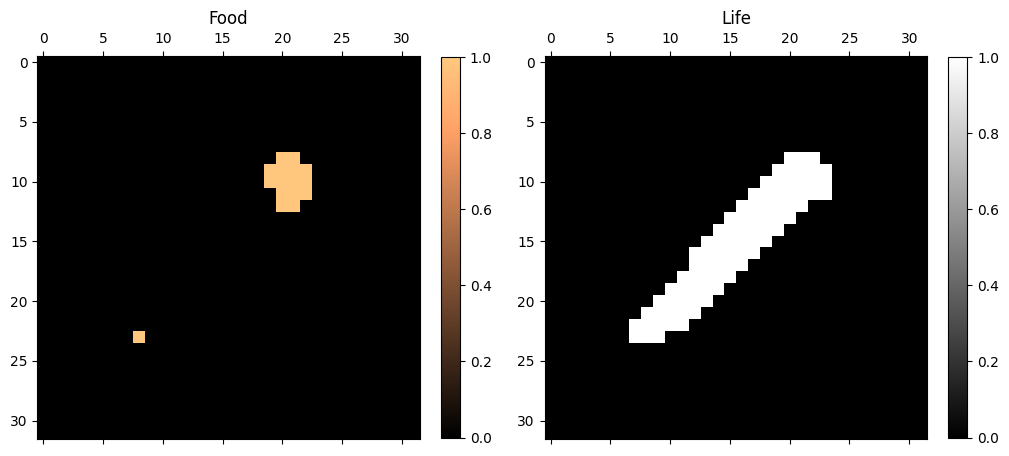

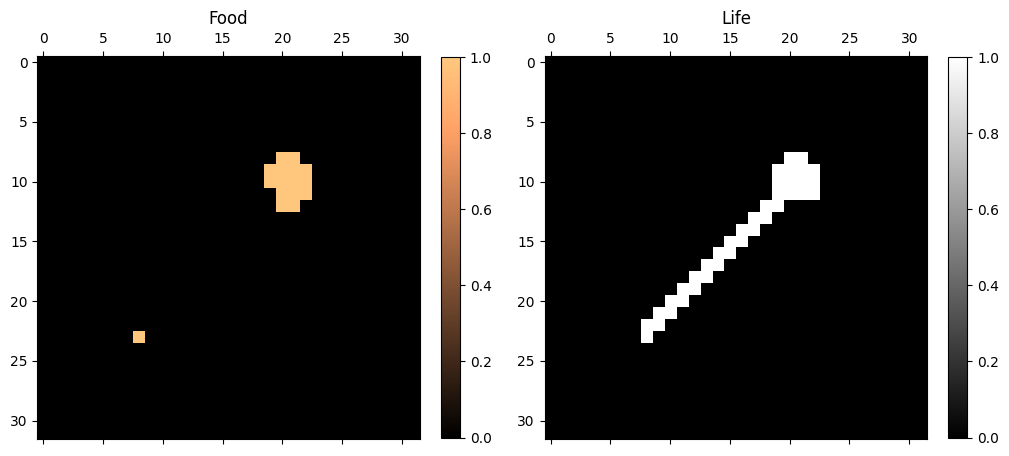

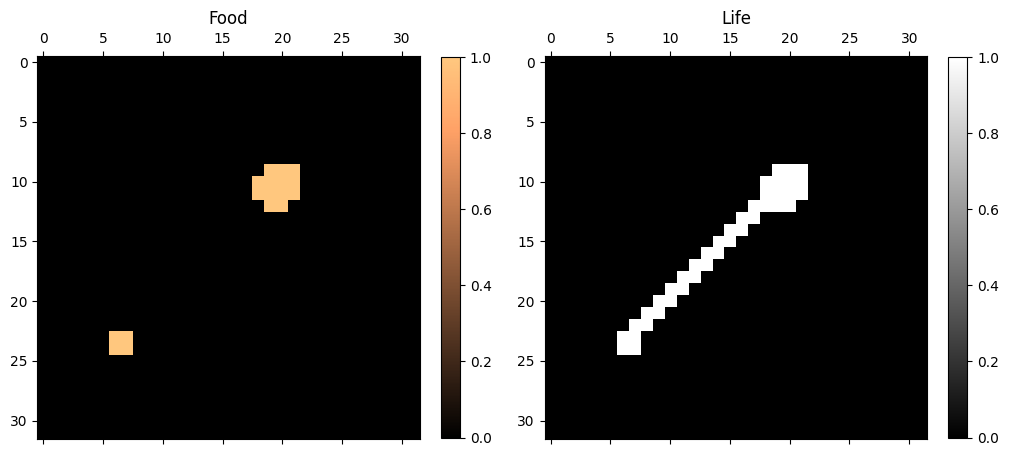

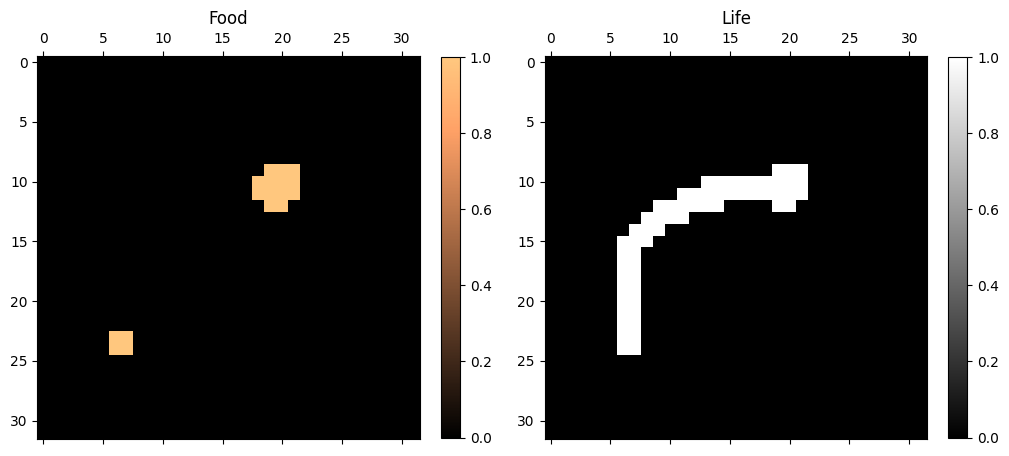

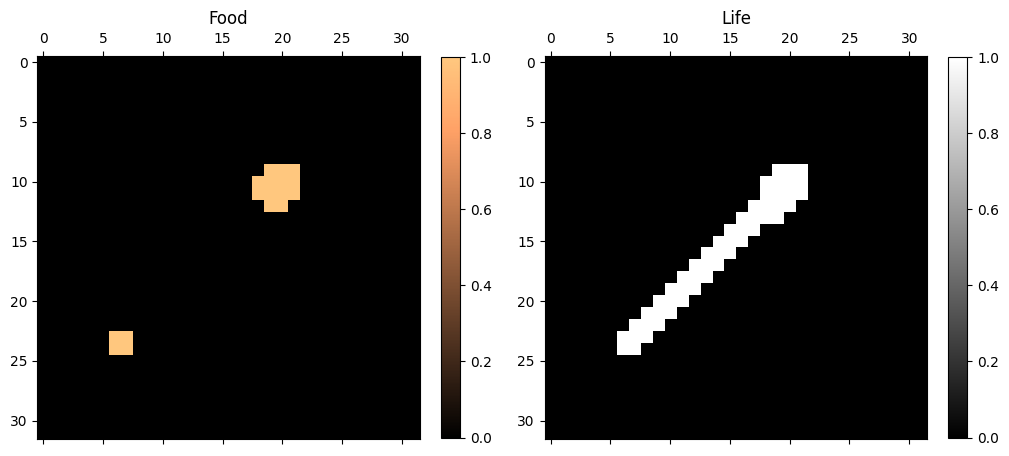

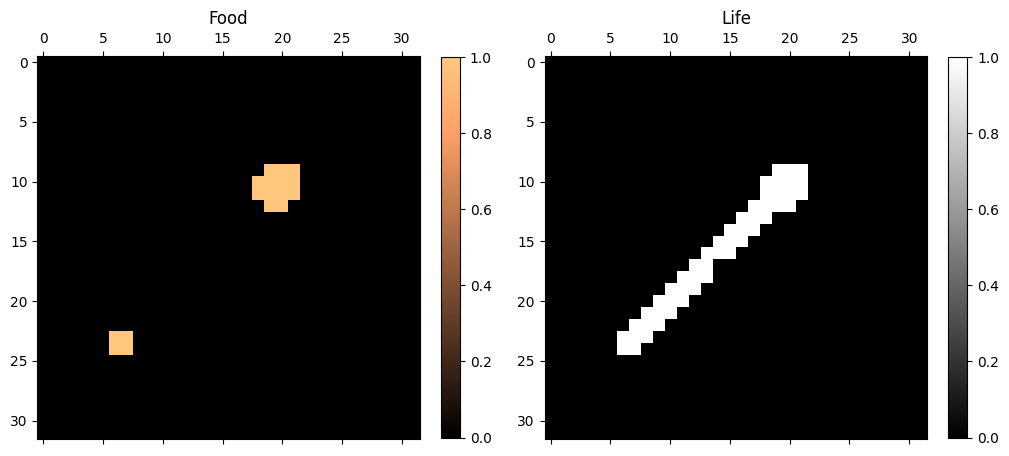

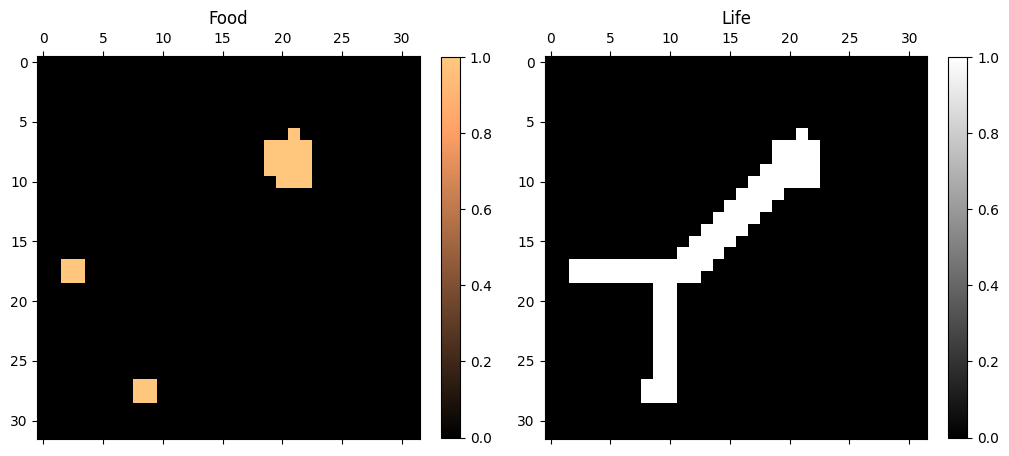

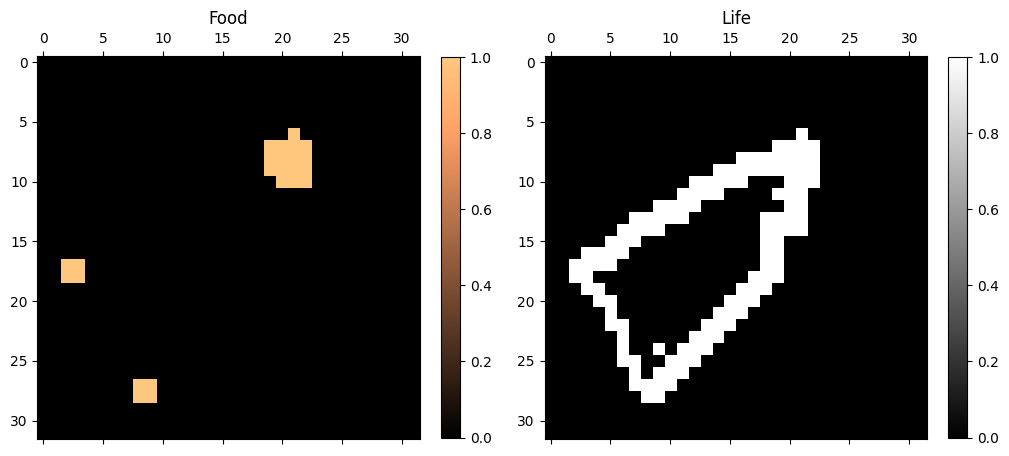

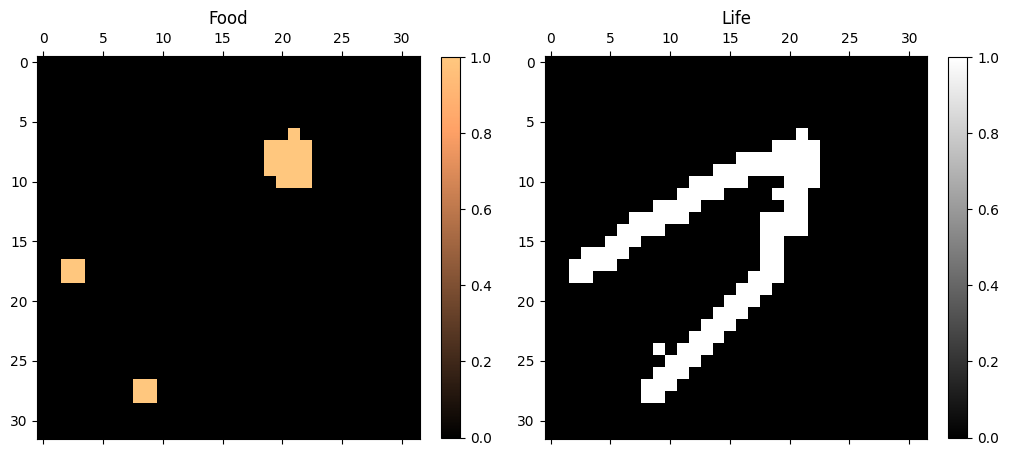

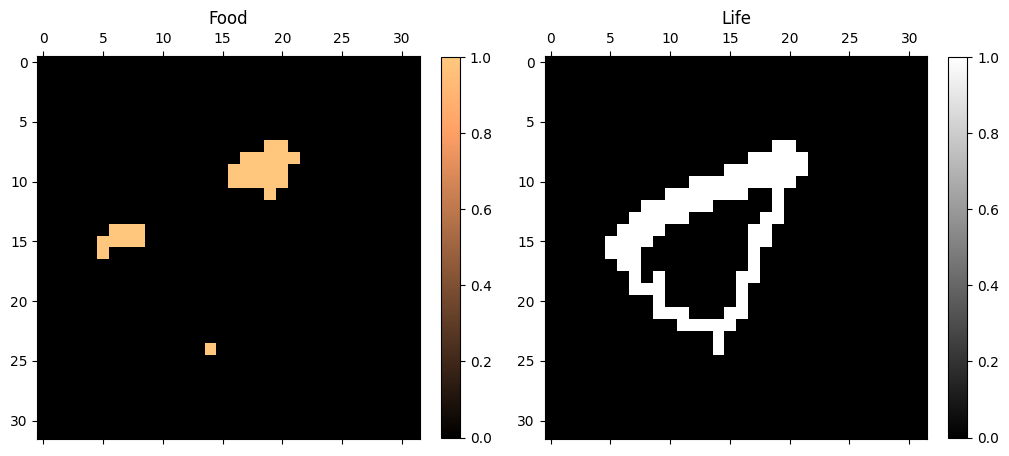

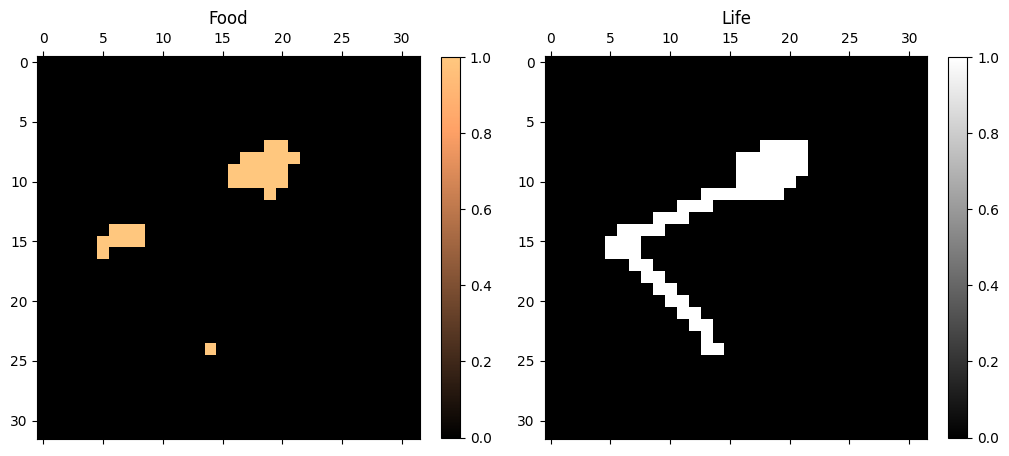

In [870]:
import eval_env
importlib.reload(eval_env)
tenvs = eval_env.load_tests()

In [864]:
tenvs

{'1': {'1': <ca_environment.CAEnvironment at 0x7fe70c7b7610>,
  '2': <ca_environment.CAEnvironment at 0x7fe6eaf752b0>,
  '3': <ca_environment.CAEnvironment at 0x7fe6c8ee1af0>},
 '5': {'1': <ca_environment.CAEnvironment at 0x7fe6c871b430>,
  '3': <ca_environment.CAEnvironment at 0x7fe6c85e00a0>,
  '2': <ca_environment.CAEnvironment at 0x7fe6ea8ffa60>,
  '4': <ca_environment.CAEnvironment at 0x7fe6b8726eb0>},
 '11': {'3': <ca_environment.CAEnvironment at 0x7fe70c9c1e50>,
  '2': <ca_environment.CAEnvironment at 0x7fe70c981400>,
  '1': <ca_environment.CAEnvironment at 0x7fe70c7bc430>},
 '10': {'1': <ca_environment.CAEnvironment at 0x7fe6eb60f610>,
  '2': <ca_environment.CAEnvironment at 0x7fe6eb622850>}}

In [11]:
for fkey in tenvs.keys():
    for ekey in tenvs[fkey].keys():
        print(fkey,ekey)
        tenvs[fkey][ekey].display()

NameError: name 'tenvs' is not defined

In [272]:
(np.random.random(2))*2-1

array([ 0.58502618, -0.23666956])

In [212]:
def random_walk(chunk, foveal, env):
    out = (np.random.random(2))*2-1
    out = np.append(out,foveal,axis=0)
    out = np.append(out,np.zeros((env.n_hidden))+1, axis=0)
    return out

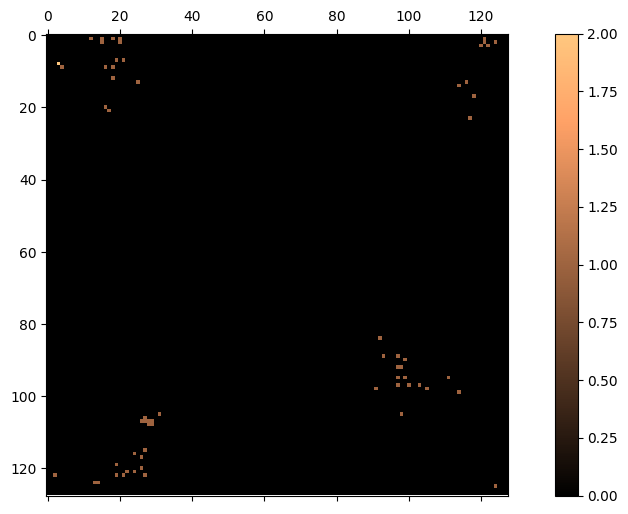

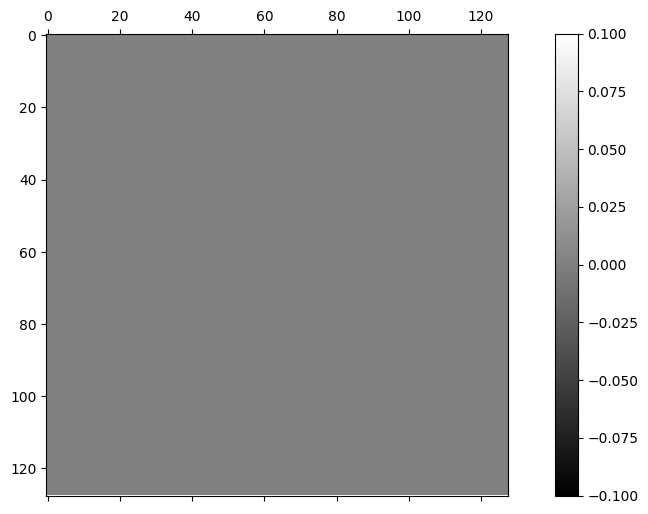

In [279]:
importlib.reload(caag)
importlib.reload(caenv)
wenv = caenv.CAEnvironment()
w_ragent = caag.CAAgent(kernel="moore")
w_ragent.set_walk_func(random_walk)
wenv.update_shape((w_ragent.n_spatial_chs + 1, 128, 128), n_hidden_chs=w_ragent.n_spatial_chs)

wenv.food_amt = 64
wenv.beta = 1
wenv.alpha = 0.7
wenv.gen_padded_food()
wenv.display()

4.0

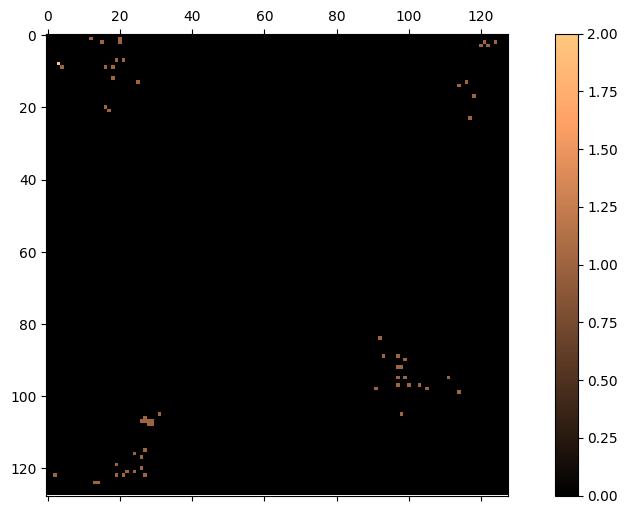

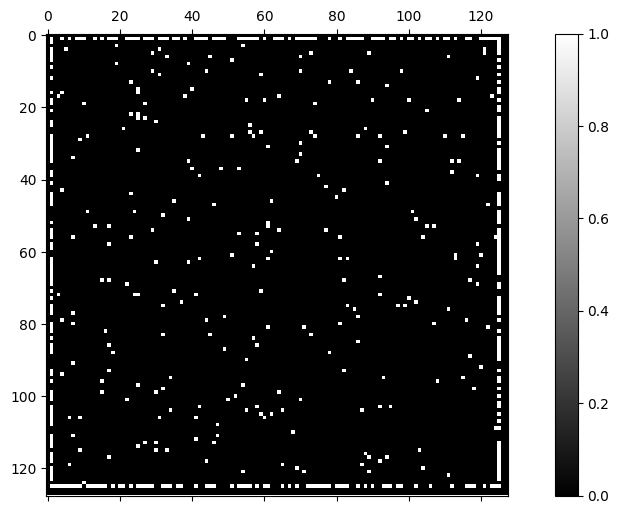

In [280]:
f = w_ragent.apply_walk_to_env(wenv, max_steps=1000)
wenv.display(channels=(0,3))
f


In [159]:
# wenv = caenv.CAEnvironment()
# wenv.update_shape((3 + 1, 128, 128), n_hidden_chs=3)
# wenv.food_amt = 64
# wenv.beta = 1
# wenv.alpha = 0.7
# wenv.gen_padded_food()
# wenv.display()

for i,n in enumerate(np.linspace(8192,50,10)):
    wenv = caenv.CAEnvironment()
    wenv.update_shape((3 + 1, 128, 128), n_hidden_chs=3)
    wenv.food_amt = int(n)
    # print(wenv.food_amt)
    wenv.beta = 0.3
    wenv.alpha = 0.22
    wenv.gen_padded_food()
    # wenv.display(channels=[0])
    a = wenv.channels.flatten()
    np.savetxt(f'./walk_test_envs/{i}.txt', a, fmt='%d')


8192
7287
6382
5478
4573
3668
2764
1859
954
50


8192
7287
6382
5478
4573
3668
2764
1859
954
50


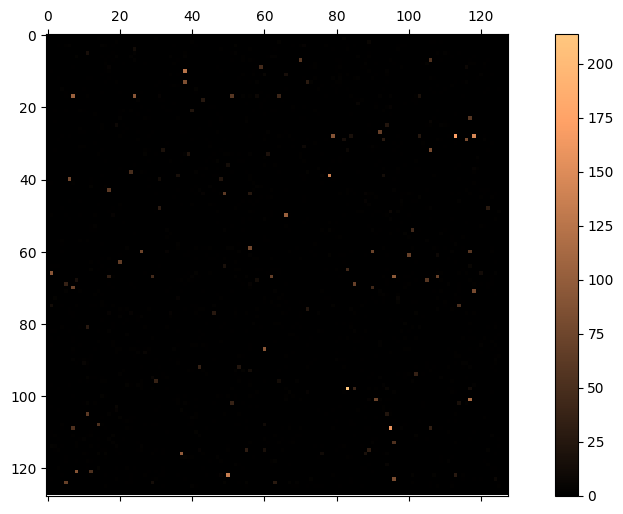

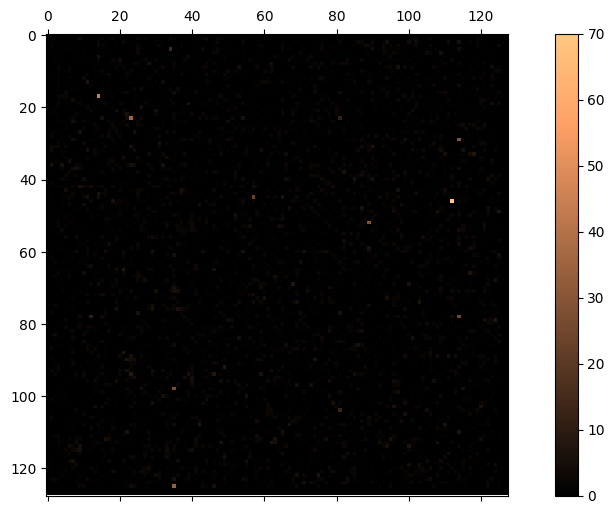

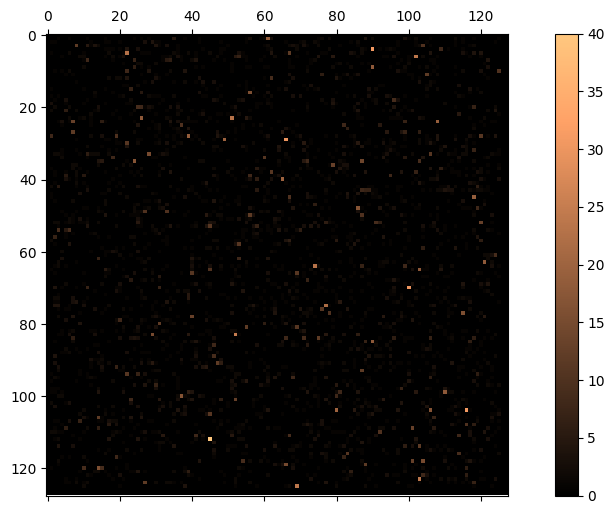

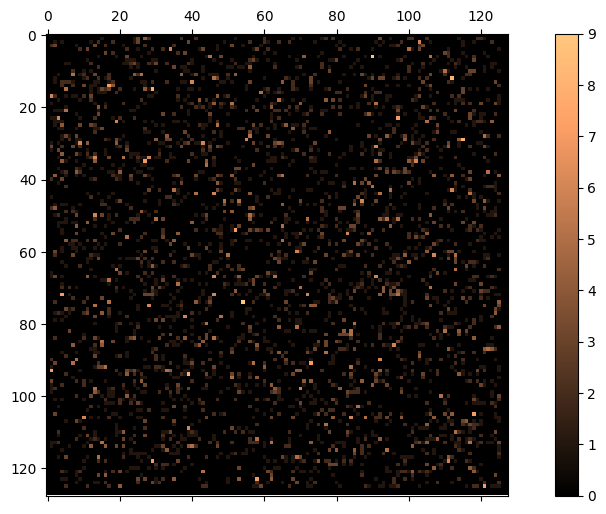

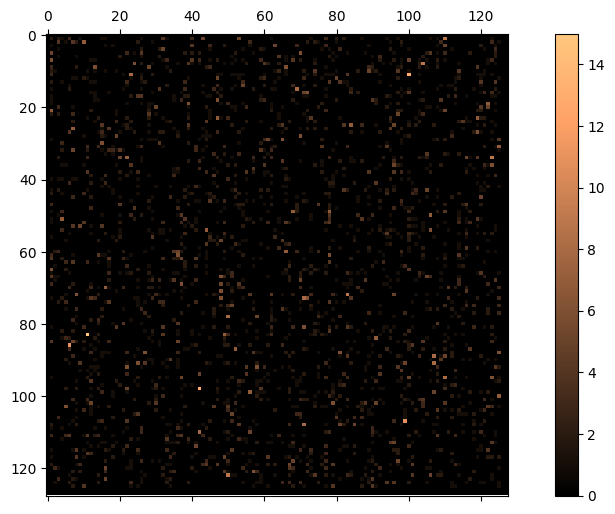

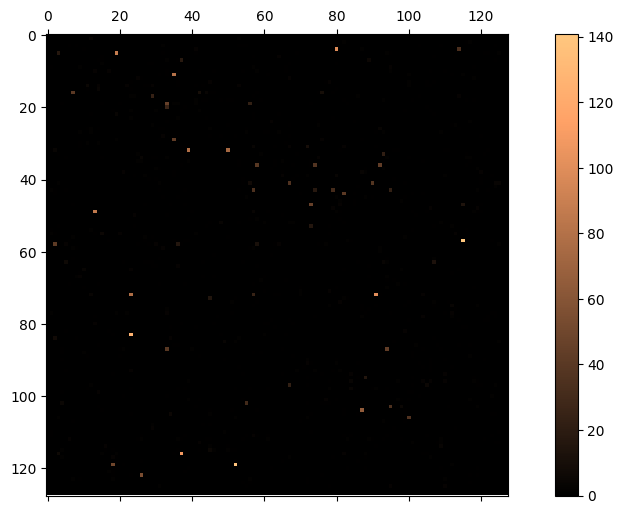

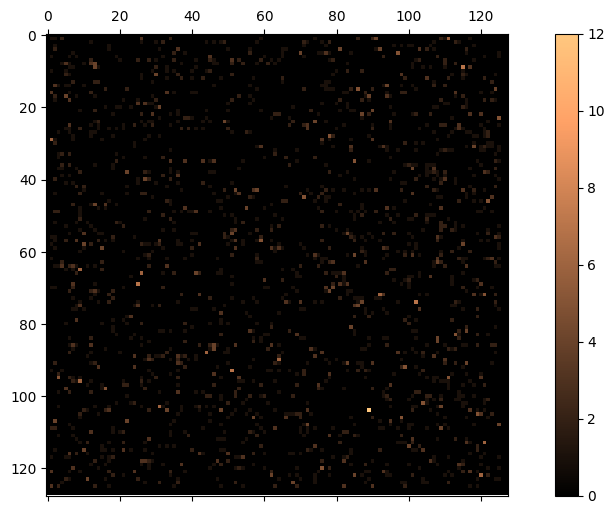

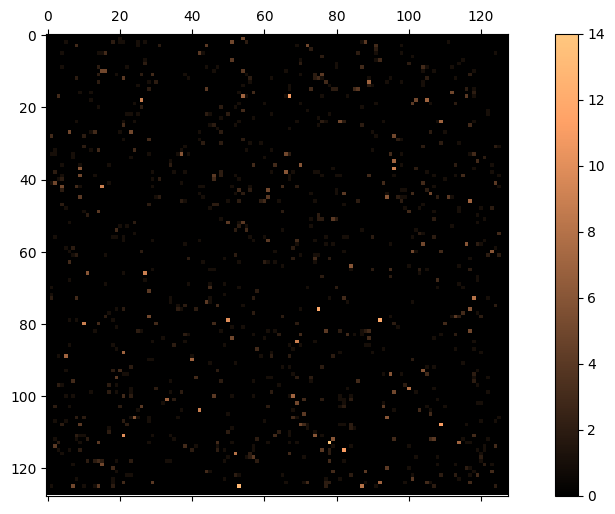

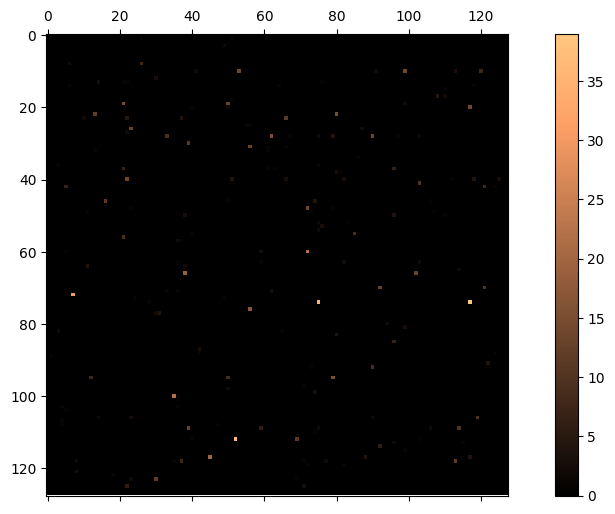

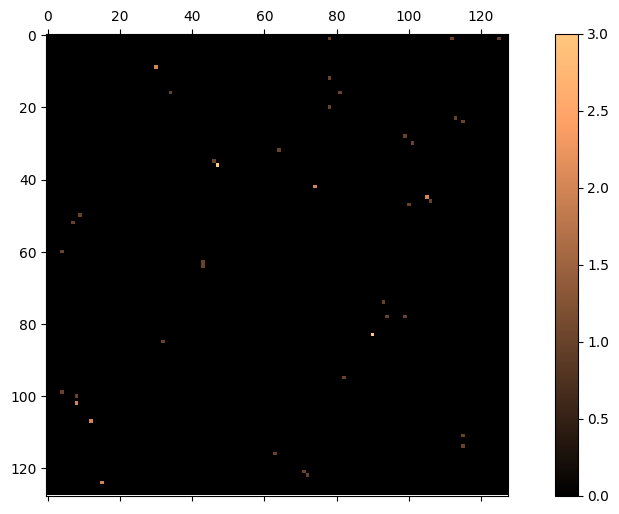

In [157]:
# for i in np.linspace(8192,50,10):
#     wenv = caenv.CAEnvironment()
#     wenv.update_shape((3 + 1, 128, 128), n_hidden_chs=3)
#     wenv.food_amt = int(i)
#     print(wenv.food_amt)
#     wenv.beta = 0.3
#     wenv.alpha = 0.22
#     wenv.gen_padded_food()
#     wenv.display(channels=[0])

In [360]:
def fitness_function(net, env=None, max_steps=1000, log=False, vid_speed=10):
   # env = caenv.CAEnvironment()
   # env.update_shape((3 + 1, 128, 128), n_hidden_chs=3)
   # chs = np.loadtxt(f"./test_envs/{int((time.time()*2)%100)}.txt", dtype = float)
   # env.channels = chs.reshape(env.eshape)

   agent = caag.CAAgent(kernel = "von_n")
   
   def walk_func(chunk, foveal, env):
      return net.activate(np.append(chunk.flatten(), foveal.flatten()))

   agent.set_walk_func(walk_func)
   agent.foveal_size = 4
   agent.n_spatial_chs = 3
   out =  agent.apply_walk_to_env(env, max_steps=1000, log=log, vid_speed=vid_speed)
   return out

In [163]:
np.savetxt("./neat_stuff/curr_env.txt", [0], fmt='%d')

In [317]:
def eval_genomes(genomes, config):
    env = caenv.CAEnvironment()
    env.update_shape((3 + 1, 128, 128), n_hidden_chs=3)
    curr_env = np.loadtxt("./neat_stuff/curr_env.txt", dtype=float)
    curr_env = (curr_env + 1/3) % 10
    np.savetxt("./neat_stuff/curr_env.txt", [curr_env], fmt='%f')
    chs = np.loadtxt(f"./walk_test_envs/{int(curr_env)}.txt", dtype = float)
    # print(f"./walk_test_envs/{int(curr_env)}.txt")
    for genome_id, genome in genomes:
        env.channels = np.copy(chs.reshape(env.eshape))
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = fitness_function(net, env=env)

In [338]:
config_file = './neat_stuff/neat.config'

# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        config_file)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
# p.add_reporter(neat.Checkpointer(5))

In [339]:
# Run for up to 300 generations.
winner = p.run(eval_genomes, 300)


 ****** Running generation 0 ****** 

Population's average fitness: 18.91000 stdev: 26.04173
Best fitness: 118.00000 - size: (9, 216) - species 1 - id 129
Average adjusted fitness: 0.160
Mean genetic distance 1.239, standard deviation 0.169
Population of 200 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   200    118.0    0.160     0
Total extinctions: 0
Generation time: 17.104 sec

 ****** Running generation 1 ****** 

Population's average fitness: 29.39500 stdev: 29.31551
Best fitness: 127.00000 - size: (9, 216) - species 1 - id 129
Average adjusted fitness: 0.231
Mean genetic distance 1.286, standard deviation 0.150
Population of 200 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   200    127.0    0.231     0
Total extinctions: 0
Generation time: 16.684 sec (16.894 average)

 ****** Running generation 2 ****** 

Population's average fitness: 


Best genome:
Key: 59130
Fitness: 540.0
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.01071559502907593, response=1.0, activation=clamped, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.05349957639293018, response=1.0, activation=clamped, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=0.5520938734814977, response=1.0, activation=clamped, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=1.3259585317622455, response=1.0, activation=clamped, aggregation=sum)
	4 DefaultNodeGene(key=4, bias=0.584457799329704, response=1.0, activation=clamped, aggregation=sum)
	5 DefaultNodeGene(key=5, bias=0.5505159389349406, response=1.0, activation=clamped, aggregation=sum)
	6 DefaultNodeGene(key=6, bias=-0.28830071878184066, response=1.0, activation=clamped, aggregation=sum)
	7 DefaultNodeGene(key=7, bias=-1.0576668111696867, response=1.0, activation=clamped, aggregation=sum)
	8 DefaultNodeGene(key=8, bias=1.4584054255322245, response=1.0, activation=clamped, aggregation=sum)
	11402 DefaultNodeGene(key=114

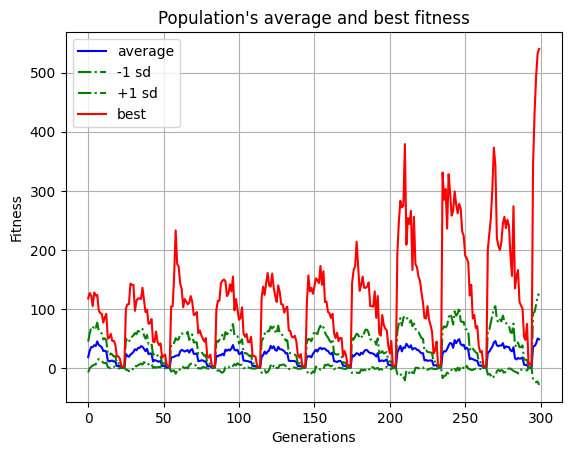

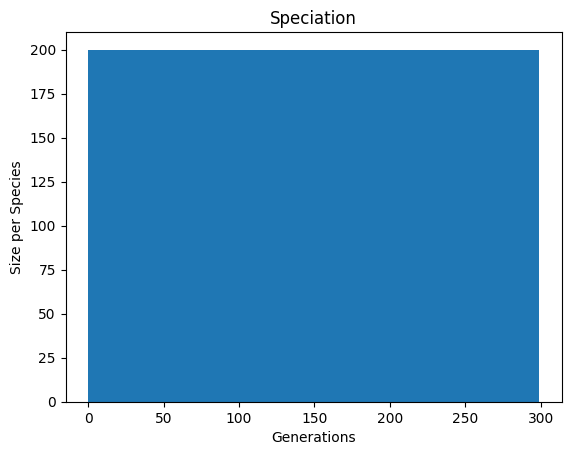

In [340]:
# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
# for xi, xo in zip(xor_inputs, xor_outputs):
#     output = winner_net.activate(xi)
#     print("input {!r}, expected output {!r}, got {!r}".format(
#         xi, xo, output))

# node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}
visualize.draw_net(config, winner, True)#, node_names=node_names)
# visualize.draw_net(config, winner, True,
#                    node_names=node_names, prune_unused=True)
visualize.plot_stats(stats, ylog=False, view=True)
visualize.plot_species(stats, view=True)

# p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
# p.run(eval_genomes, 10)

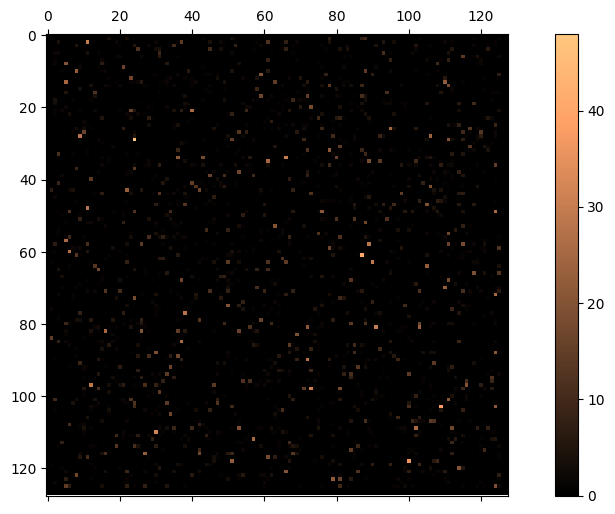

In [413]:
env = caenv.CAEnvironment()
env.update_shape((3 + 1, 128, 128), n_hidden_chs=3)
curr_env = np.loadtxt("./neat_stuff/curr_env.txt", dtype=float)
# curr_env = (curr_env + 1/3) % 10
# np.savetxt("./neat_stuff/curr_env.txt", [curr_env], fmt='%f')
chs = np.loadtxt(f"./walk_test_envs/{int(curr_env)}.txt", dtype = float)
env.channels = np.copy(chs.reshape(env.eshape))
env.display(channels=[0])

In [414]:
importlib.reload(caag)
f,hist = fitness_function(winner_net, env, max_steps = 100, log=True, vid_speed=2)
f

520.0

In [415]:
Video(env.gen_video())

In [382]:
import pandas as pd

df = pd.DataFrame(hist, columns=["x","y"])


In [391]:
df['x1'] = df.x.shift(1)
df['y1'] = df.y.shift(1)


In [396]:
dists = np.linalg.norm(df[['x1','y1']][1:].values - df[['x','y']][1:].values, axis=1)

(-10.0, 128.0)

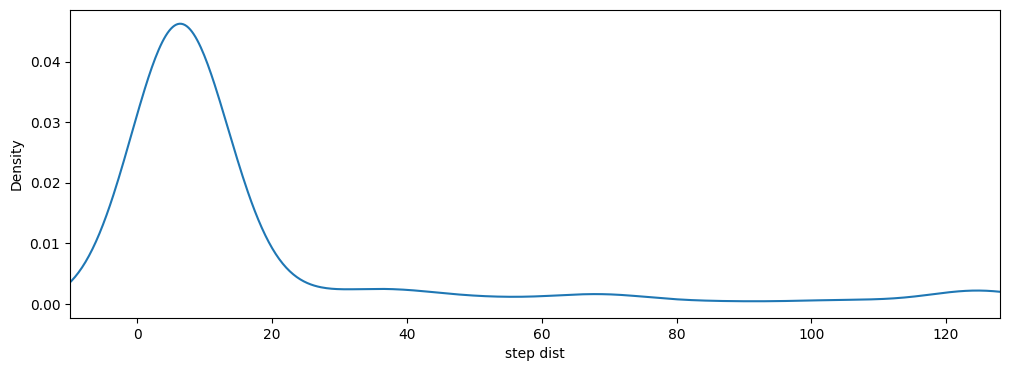

In [410]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(12, 4))
df['d']=np.append([0],dists)
df['d'].plot(kind='density', ax=axs)
plt.xlabel("step dist")
plt.xlim((-10,128))

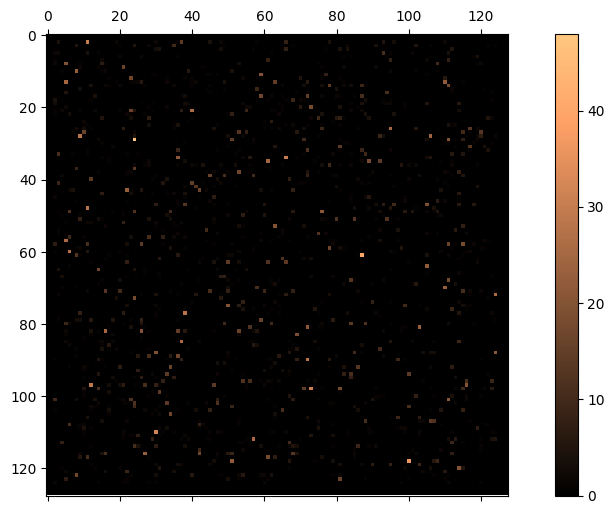

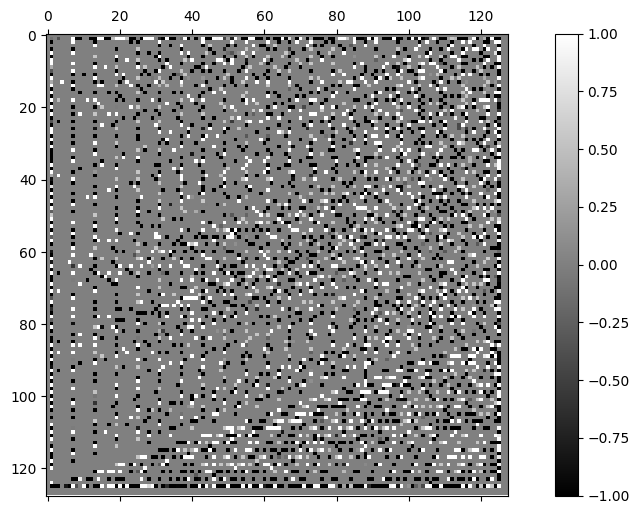

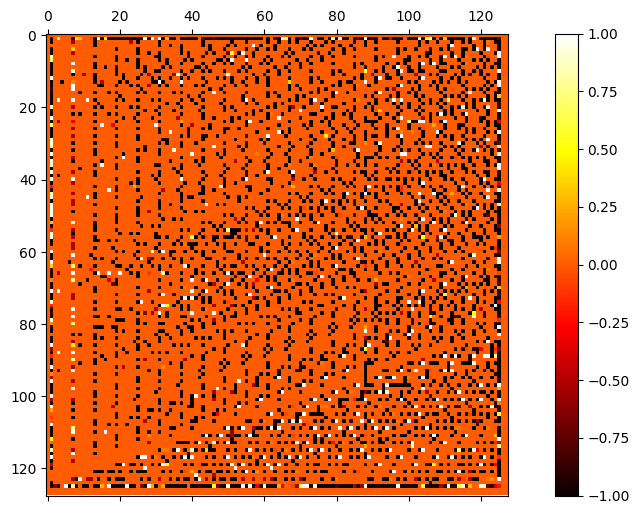

In [359]:
env.display(channels=[0,1,2], cmaps = [cm.copper,cm.gray,cm.hot])